In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyPDMP.models import VAE
from pyPDMP.utils import loss_function
import pyPDMP.utils as utils
from pyPDMP.utils import HDSint

## Define Variables and parameters of the PDMP Model
ODE:
$$\begin{bmatrix}\dot{x}\\ \dot{v}\end{bmatrix} = \begin{bmatrix}v\\ -kx - bv\end{bmatrix}$$

In [3]:
k = 2                            # Spring Stiffness
b = 2                            # Damping coeff.
x0 = [5,0]                       # Initial Condition
t = np.linspace(0,10,1000)       # flow time span
Sigma = np.array([[5,0],[0,5]])  # Cov. of jump space dist. (Normal)
mu = np.array([0,0])             # Mean of jump space dist. (Normal)
tau = 0.4                        # Time constant of time jump space dist. (Cumulative Exp.)

# ODE of the flows
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

## Generate Data

In [4]:
# Integrate Hybrid System
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


Text(0.5, 0, 't')

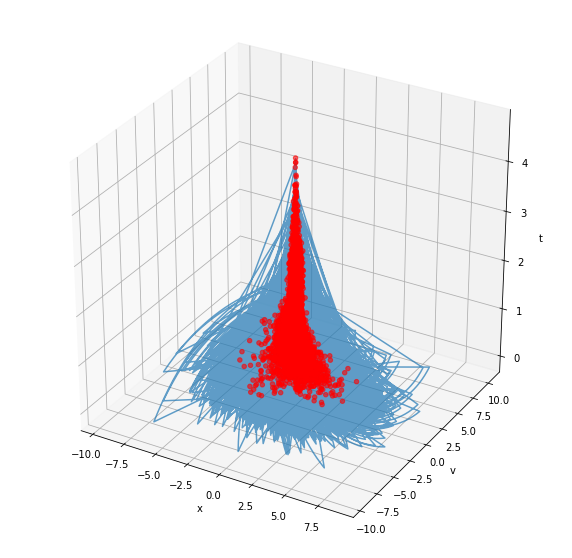

In [5]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot(xs = Xtot[:,0], ys = Xtot[:,1],zs = Xtot[:,2],alpha = 0.7)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

### Create and load dataset

In [20]:
# Create Labels - NOT NEEDED FOR VAE
y = torch.tensor([1 for i in range(Xevent.shape[0])])

X = torch.tensor(Xevent).float()

print(X.shape,y.shape)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

torch.Size([5000, 3]) torch.Size([5000])


## Training the VAE

In [21]:
m = VAE(i=3, lec=400, lds=20, ldec=400, out=3)
m

VAE(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=3, bias=True)
)

In [22]:
dataset = torch.utils.data.TensorDataset(X,y)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=32, 
                                          shuffle=True)

In [23]:
size = 3

def train(m, loader, epoch):
    optimizer = torch.optim.SGD(m.parameters(), lr=1e-6)
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(loader):
        # flatten the batch
        x = x.view(-1, size)
        optimizer.zero_grad()
        recon_batch, mu, logvar = m(x)
        loss = loss_function(recon_batch, x.view(-1,size), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(loader.dataset),
                100. * batch_idx / len(loader),
                loss.item() / len(x)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(loader.dataset)))

In [27]:
epochs = 100

for i in range(epochs):
    train(m, data_loader, i)

Train Epoch: 0 [0/5000 (0%)]	Loss: -9.993382
Train Epoch: 0 [3200/5000 (64%)]	Loss: -6.470004
====> Epoch: 0 Average loss: -7.6620
Train Epoch: 1 [0/5000 (0%)]	Loss: -6.670983
Train Epoch: 1 [3200/5000 (64%)]	Loss: -9.306400
====> Epoch: 1 Average loss: -7.7162
Train Epoch: 2 [0/5000 (0%)]	Loss: -8.123022
Train Epoch: 2 [3200/5000 (64%)]	Loss: -6.638864
====> Epoch: 2 Average loss: -7.7786
Train Epoch: 3 [0/5000 (0%)]	Loss: -9.273452
Train Epoch: 3 [3200/5000 (64%)]	Loss: -5.680111
====> Epoch: 3 Average loss: -8.0257
Train Epoch: 4 [0/5000 (0%)]	Loss: -4.926899
Train Epoch: 4 [3200/5000 (64%)]	Loss: -6.960830
====> Epoch: 4 Average loss: -8.1293
Train Epoch: 5 [0/5000 (0%)]	Loss: -8.603882
Train Epoch: 5 [3200/5000 (64%)]	Loss: -7.400587
====> Epoch: 5 Average loss: -8.1896
Train Epoch: 6 [0/5000 (0%)]	Loss: -4.431540
Train Epoch: 6 [3200/5000 (64%)]	Loss: -5.696441
====> Epoch: 6 Average loss: -8.3569
Train Epoch: 7 [0/5000 (0%)]	Loss: -13.553667
Train Epoch: 7 [3200/5000 (64%)]	Loss

Train Epoch: 60 [3200/5000 (64%)]	Loss: -19.029659
====> Epoch: 60 Average loss: -16.0273
Train Epoch: 61 [0/5000 (0%)]	Loss: -13.288368
Train Epoch: 61 [3200/5000 (64%)]	Loss: -14.080942
====> Epoch: 61 Average loss: -16.3266
Train Epoch: 62 [0/5000 (0%)]	Loss: -13.567413
Train Epoch: 62 [3200/5000 (64%)]	Loss: -13.523028
====> Epoch: 62 Average loss: -16.4152
Train Epoch: 63 [0/5000 (0%)]	Loss: -20.839148
Train Epoch: 63 [3200/5000 (64%)]	Loss: -21.763401
====> Epoch: 63 Average loss: -16.7304
Train Epoch: 64 [0/5000 (0%)]	Loss: -19.731232
Train Epoch: 64 [3200/5000 (64%)]	Loss: -15.805915
====> Epoch: 64 Average loss: -16.8393
Train Epoch: 65 [0/5000 (0%)]	Loss: -14.031970
Train Epoch: 65 [3200/5000 (64%)]	Loss: -21.468666
====> Epoch: 65 Average loss: -17.1285
Train Epoch: 66 [0/5000 (0%)]	Loss: -20.857849
Train Epoch: 66 [3200/5000 (64%)]	Loss: -18.565483
====> Epoch: 66 Average loss: -17.3704
Train Epoch: 67 [0/5000 (0%)]	Loss: -13.847040
Train Epoch: 67 [3200/5000 (64%)]	Loss: -

In [28]:
x = data_loader.dataset.tensors[0]
y = m(x.float().view(-1,size))[0].detach().numpy()

Text(0.5, 0, 't')

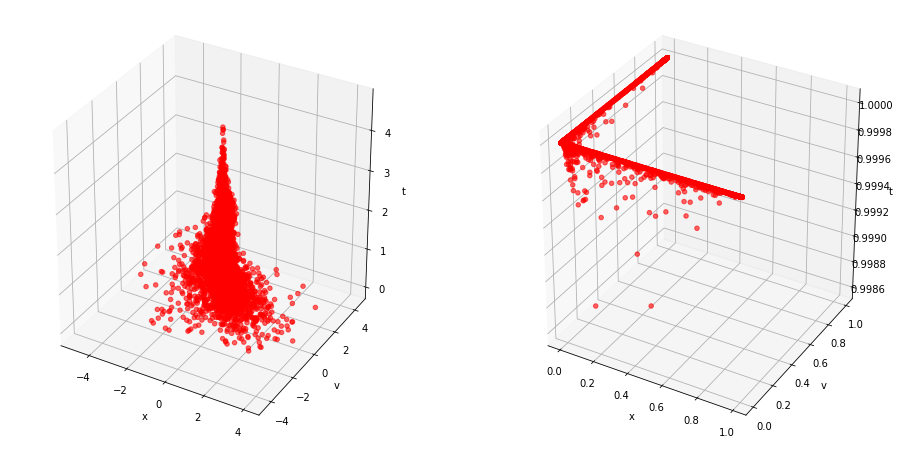

In [29]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')
#
ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(xs = y[:,0], ys = y[:,1],zs = y[:,2],alpha = .6,color = 'red')
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_zlabel('t')